In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random

import gym
from gym import spaces
import keras
from keras.layers import *
from keras.models import Model
import numpy
import rl
import scipy.sparse
import skimage.io

import sys
print(sys.version)

%matplotlib inline

Using TensorFlow backend.


3.6.5 (default, May 11 2018, 04:00:52) 
[GCC 8.1.0]


In [3]:
input_neurons = 8
inter_neurons = 128
output_neurons = 8
max_history = 16
hidden_size = 32

In [ ]:
# input_layer = Input((inter_neurons + output_neurons, max_history, input_neurons + inter_neurons + 2))
# x = TimeDistributed(Bidirectional(LSTM(hidden_size, return_sequences=True), merge_mode='concat'))(input_layer)
# x = Dropout(0.5)(x)
# x = TimeDistributed(Bidirectional(LSTM(hidden_size), merge_mode='concat'))(x)
# x = Dropout(0.5)(x)
# output_layer = TimeDistributed(Dense(input_neurons + inter_neurons, activation='tanh'))(x)
# model = Model(input_layer, output_layer)
# model.compile(optimizer='adam', loss='binary_crossentropy')
# model.summary()

In [ ]:
input_layer = Input((None, 4))
x = Bidirectional(LSTM(hidden_size, return_sequences=True), merge_mode='concat')(input_layer)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(hidden_size), merge_mode='concat')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

In [ ]:
# class SNN(gym.Env):
    
#     def __init__(self, specification):
#         self.specification = specification
#         self.action_space = gym.spaces.Box(-1, 1, (self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons']))
#         self.observation_space = gym.spaces.Box(-1, 1, (self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['max_history'], self.specification['input_neurons'] + self.specification['inter_neurons'] + 2))
#         self.potential_matrix = numpy.zeros((self.specification['input_neurons'] + self.specification['inter_neurons'] + self.specification['output_neurons'],))
#         self.weight_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons']))
#         self.weight_mask = numpy.ones_like(self.weight_matrix, dtype=numpy.uint8)
#         self.weight_mask[-self.specification['output_neurons']:, :self.specification['input_neurons']] = 0
#         numpy.fill_diagonal(self.weight_mask[:self.specification['inter_neurons'], -self.specification['inter_neurons']:], 0)
#         self.history_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['max_history'], self.specification['input_neurons'] + self.specification['inter_neurons'] + 2))
#         self.random_seed = None
#         self.next_input = None
#         self.previous_reward = None
    
#     def interconnect(self, weight_density):
#         sparse_matrix = scipy.sparse.random(self.weight_matrix.shape[0], self.weight_matrix.shape[1], density=weight_density, random_state=self.random_seed)
#         sparse_matrix.data *= 2
#         sparse_matrix.data -= 1
#         self.weight_matrix = numpy.multiply(sparse_matrix.toarray(), self.weight_mask)
    
#     def close(self):
#         self.specification['environment'].close()
        
#     def reset(self):
#         self.next_input = self.specification['environment'].reset()
#         self.previous_reward = None
#         self.potential_matrix[:] = 0
#         if self.specification['neuroplasticity']:
#             self.history_matrix[:, :, :] = 0
#         return self.history_matrix
    
#     def seed(self, seed):
#         self.random_seed = seed
#         return self.specification['environment'].seed(self.random_seed)
    
#     def step(self, action):
#         if self.specification['neuroplasticity']:
#             self.weight_matrix = numpy.clip(numpy.multiply(numpy.add(self.weight_matrix, self.specification['learning_rate'] * action), self.weight_mask), -1, 1)
#         self.potential_matrix[:self.specification['input_neurons']] = numpy.add(self.potential_matrix[:self.specification['input_neurons']], self.next_input)
#         firing_matrix = numpy.vectorize(lambda x: x >= 1)(self.potential_matrix)
#         for i in range(self.specification['inter_neurons'] + self.specification['output_neurons']):
#             pos = self.specification['input_neurons'] + i
#             deltas = numpy.multiply(firing_matrix[:-self.specification['output_neurons']], self.weight_matrix[i])
#             if self.specification['neuroplasticity']:
#                 self.history_matrix[i, self.specification['max_history'] - 1, :] = numpy.concatenate([self.potential_matrix[pos:pos + 1], firing_matrix[pos:pos + 1], deltas])
#             self.potential_matrix[pos] += numpy.sum(deltas)
#         self.potential_matrix = numpy.clip(numpy.multiply(self.potential_matrix, numpy.invert(firing_matrix)), -1, 1)
#         if self.specification['neuroplasticity']:
#             self.history_matrix = numpy.roll(self.history_matrix, 1, axis=1)
#         self.next_input, current_reward, terminal, _ = self.specification['environment'].step(firing_matrix[-self.specification['output_neurons']:])
#         reward = 0 if self.previous_reward is None else current_reward - self.previous_reward
#         self.previous_reward = current_reward
#         return self.history_matrix, reward, terminal, {}

In [130]:
class SNN(gym.Env):
    
    def __init__(self, specification):
        self.specification = specification
#         self.action_space = gym.spaces.Box(-1, 1, (self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons']))
        self.action_space = gym.spaces.Discrete(3)
#         self.observation_space = gym.spaces.Box(-1, 1, (self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['max_history'], self.specification['input_neurons'] + self.specification['inter_neurons'] + 2))
        self.observation_space = gym.spaces.Box(-1, 1, (self.specification['max_history'], 4))
        self.potential_matrix = numpy.zeros((self.specification['input_neurons'] + self.specification['inter_neurons'] + self.specification['output_neurons'],))
        self.weight_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons']))
        self.weight_mask = numpy.ones_like(self.weight_matrix, dtype=numpy.uint8)
        self.weight_mask[-self.specification['output_neurons']:, :self.specification['input_neurons']] = 0
        numpy.fill_diagonal(self.weight_mask[:self.specification['inter_neurons'], -self.specification['inter_neurons']:], 0)
#         self.history_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['max_history'], self.specification['input_neurons'] + self.specification['inter_neurons'] + 2))
        self.history_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons'], self.specification['max_history'], 4))
        self.neuron_idx = 0
        self.weight_idx = 0
        self.random_seed = None
        self.next_input = None
        self.previous_reward = None
    
    def interconnect(self):
        self.weight_matrix = numpy.zeros_like(self.weight_matrix)
        probabilities = numpy.vectorize(lambda i, j: 1 / abs(i - j) if i != j else 0.)(*numpy.meshgrid(range(self.specification['inter_neurons']), range(self.specification['inter_neurons'])))
        mask = numpy.zeros((self.weight_matrix.shape[0], self.weight_matrix.shape[1]))
        mask[:-self.specification['output_neurons'], self.specification['input_neurons']:] = numpy.random.binomial(1, probabilities, (self.specification['inter_neurons'], self.specification['inter_neurons']))
        mask[:self.specification['inter_neurons'], :self.specification['input_neurons']] = numpy.eye(self.specification['input_neurons'])[numpy.random.choice(self.specification['input_neurons'], self.specification['inter_neurons'])]
        mask[self.specification['inter_neurons']:, self.specification['input_neurons']:] = numpy.eye(self.specification['output_neurons'])[numpy.random.choice(self.specification['output_neurons'], self.specification['inter_neurons'])].swapaxes(0, 1)
        rand1 = numpy.random.uniform(0, 1, (self.weight_matrix.shape[0], self.weight_matrix.shape[1]))
        rand1[:-self.specification['output_neurons'], self.specification['input_neurons']:] = rand1[:-self.specification['output_neurons'], self.specification['input_neurons']:] * 2 - 1
        rand2 = numpy.random.uniform(0, 1, (self.weight_matrix.shape[0], self.weight_matrix.shape[1]))
        self.weight_matrix = mask * rand1 * rand2 * self.weight_mask
#         sparse_matrix = scipy.sparse.random(self.weight_matrix.shape[0], self.weight_matrix.shape[1], density=weight_density, random_state=self.random_seed)
#         sparse_matrix.data *= 2
#         sparse_matrix.data -= 1
#         self.weight_matrix = numpy.multiply(sparse_matrix.toarray(), self.weight_mask)
    
    def load_weights(self, weights):
        pass
    
    def close(self):
        self.specification['environment'].close()
        
    def reset(self):
        self.next_input = self.specification['environment'].reset()
#         self.neuron_idx = 0
#         self.weight_idx = 0
        self.previous_reward = None
#         self.potential_matrix[:] = 0
#         if self.specification['neuroplasticity']:
#             self.history_matrix[:, :, :] = 0
        return self.history_matrix[self.neuron_idx, self.weight_idx, :, :]
    
    def render(self, mode='human'):
        return self.specification['environment'].render(mode)
    
    def seed(self, seed):
        numpy.random.seed(seed)
        self.random_seed = seed
        return self.specification['environment'].seed(self.random_seed)
    
    def step(self, action):
        self.next_input = np.eye(self.specification['input_neurons'])[np.random.choice(self.specification['input_neurons'], 1)]
#         self.neuron_idx += 1
#         self.weight_idx += 1
#         if self.neuron_idx == self.weight_matrix.shape[0]:
#             self.neuron_idx = 0
#         if self.weight_idx == self.weight_matrix.shape[1]:
#             self.weight_idx = 0
#         print(action)
#         print(self.neuron_idx, self.weight_idx)
        if self.specification['neuroplasticity']:
#             self.weight_matrix = numpy.clip(numpy.multiply(numpy.add(self.weight_matrix, self.specification['learning_rate'] * action), self.weight_mask), -1, 1)
            self.weight_matrix[self.neuron_idx, self.weight_idx] += self.specification['learning_rate'] * (action - 1)
            self.weight_matrix = numpy.clip(numpy.multiply(self.weight_matrix, self.weight_mask), -1, 1)
        state = numpy.zeros_like(self.history_matrix[self.neuron_idx, self.weight_idx, :, :])
        reward = 0
        terminal = False
        if self.neuron_idx == 0 and self.weight_idx == 0:
            self.potential_matrix[:self.specification['input_neurons']] = numpy.add(self.potential_matrix[:self.specification['input_neurons']], self.next_input)
            firing_matrix = numpy.vectorize(lambda x: x >= 1)(self.potential_matrix)
            for i in range(self.specification['inter_neurons'] + self.specification['output_neurons']):
                pos = self.specification['input_neurons'] + i
                deltas = numpy.multiply(firing_matrix[:-self.specification['output_neurons']], self.weight_matrix[i])
                delta = numpy.sum(deltas)
                if self.specification['neuroplasticity']:
                    self.history_matrix[i, self.weight_idx, self.specification['max_history'] - 1, :] = numpy.array([deltas[self.weight_idx], delta, self.potential_matrix[pos], firing_matrix[pos]])
                self.potential_matrix[pos] += delta
            self.potential_matrix = numpy.clip(numpy.multiply(self.potential_matrix, numpy.invert(firing_matrix)), -1, 1)
            if self.specification['neuroplasticity']:
                self.history_matrix = numpy.roll(self.history_matrix, 2, axis=1)
            state = self.history_matrix[self.neuron_idx, self.weight_idx, :, :]
            self.next_input, reward, terminal, _ = self.specification['environment'].step(firing_matrix[-self.specification['output_neurons']:].astype(int))
#             reward = 0 if self.previous_reward is None else current_reward - self.previous_reward
#             self.previous_reward = current_reward
#         if self.weight_idx == self.specification['input_neurons'] + self.specification['inter_neurons'] - 1:
#             self.weight_idx = 0
#             if self.neuron_idx == self.specification['inter_neurons'] + self.specification['output_neurons'] - 1:
#                 self.neuron_idx = 0
#             else:
# #                 print(self.neuron_idx)
#                 self.neuron_idx += 1
#         else:
#             self.weight_idx += 1
        return state, reward, terminal, {}

In [5]:
class Test(gym.Env):
    
    def __init__(self):
#         self.action_space = gym.spaces.Box(-1, 1, (2,))
        self.action_space = gym.spaces.Box(0, 1, (8,))
        self.observation_space = gym.spaces.Box(0, float('inf'), (8,))

    def close(self):
        pass

    def reset(self):
        self.state = numpy.zeros((8,))
        self.idx = 0
        return self.state

    def step(self, action):
#         print(action)
#         print(actions)
        #print(actions)
        #actions = numpy.round(actions)
#         self.state = numpy.add(self.state, numpy.array([actions[0], actions[1]]))
        self.state = numpy.add(self.state, action)
        #terminal = True
        #ones = numpy.count_nonzero(self.state)
        reward = ((self.state[1] - self.state[0]) * (self.state[2] - self.state[3])) * ((self.state[4] - self.state[5]) * (self.state[6] - self.state[7]))
        terminal = reward < 0
#         self.state = numpy.abs(numpy.add(self.state, actions))
#         terminal = min(self.state) <= 0
#         reward = self.state[0] ** self.state[1]
        self.idx += 1
        return numpy.ones(self.state.shape), reward, terminal, {}

In [6]:
class Test2(gym.Env):
    
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(0, 1, (1,))
        self.state = None
        self.idx = None
        self.random_seed = None
    
    def seed(self, seed):
        self.random_seed = seed
        random.seed(seed)
        return seed
    
    def close(self):
        pass
    
    def reset(self):
        self.state = numpy.ones((1,))
        self.idx = 0
        return self.state
    
    def step(self, action):
#         print(self.idx)
#         self.state[action] = int(not bool(self.state[action]))
#         self.state = numpy.zeros((16,))
#         self.state[self.idx] = 1
        self.idx += 1
        terminal = self.idx == 100
        if action[0] == 1:
            reward = 1.0
        else:
            reward = 0.0
        
        return self.state, reward, terminal, {}

In [ ]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

class CartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5 # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
#         assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.state
        x, x_dot, theta, theta_dot = state
        force = self.force_mag * (2 * numpy.argmax(action) - 1) if numpy.count_nonzero(action) == 1 else 0
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta* temp) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc  = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x  = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        self.state = (x,x_dot,theta,theta_dot)
        output = np.array([x < 0, x > 0, x_dot < 0, x_dot > 0, theta < 0, theta > 0, theta_dot < 0, theta_dot > 0]).astype(int)
        done =  x < -self.x_threshold \
                or x > self.x_threshold \
                or theta < -self.theta_threshold_radians \
                or theta > self.theta_threshold_radians
        done = bool(done)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
            self.steps_beyond_done += 1
            reward = 0.0

        return output, reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return numpy.zeros((8,))

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold*2
        scale = screen_width/world_width
        carty = 100 # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
            axleoffset =cartheight/4.0
            cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
            pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            pole.set_color(.8,.6,.4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5,.5,.8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0,carty), (screen_width,carty))
            self.track.set_color(0,0,0)
            self.viewer.add_geom(self.track)

        if self.state is None: return None

        x = self.state
        cartx = x[0]*scale+screen_width/2.0 # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer: self.viewer.close()

In [ ]:
import numpy
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


ENV_NAME = 'SNN'


# Get the environment and extract the number of actions.
#env = gym.make(ENV_NAME)
env = SNN({'environment': Test2(), 'input_neurons': 1, 'inter_neurons': 10, 'output_neurons': 1, 'max_history': 16, 'neuroplasticity': True, 'learning_rate': 0.1})
numpy.random.seed(0)
env.seed(0)
env.interconnect(0.1)
nb_actions = env.action_space.n
#functools.reduce(operator.mul, env.action_space.shape)

In [ ]:
skimage.io.imshow(env.weight_matrix)

In [ ]:
# Next, we build a very simple model.
model = Sequential()
model.add(Reshape((16, 4), input_shape=(1, 16, 4)))
model.add(Bidirectional(LSTM(32, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(32), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='linear'))
print(model.summary())
# model = Sequential()
# model.add(Reshape((16,), input_shape=(1, 16)))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(nb_actions, activation='linear'))
# print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

In [ ]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, visualize=False, verbose=2, nb_episodes=1)

In [148]:
env = SNN({'environment': Test2(), 'input_neurons': 10, 'inter_neurons': 100, 'output_neurons': 10, 'max_history': 16, 'neuroplasticity': True, 'learning_rate': 0.1})
numpy.random.seed(0)
env.seed(0)
env.interconnect()
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

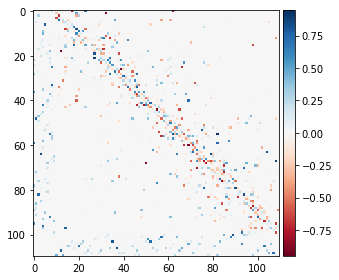

In [146]:
skimage.io.imshow(env.weight_matrix)

In [144]:
for i in range(100):
    stuff = env.step(1)

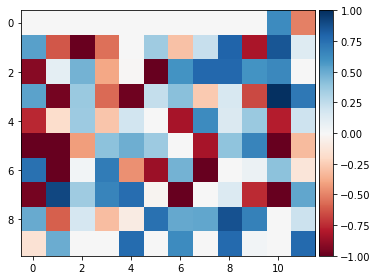

In [145]:
skimage.io.imshow(env.potential_matrix.reshape((10, 12)))

In [ ]:
test = Test()

In [ ]:
import functools
import operator

In [ ]:
# import numpy as np
# import gym

# from keras.models import Sequential
# from keras.layers import Dense, Activation, Flatten
# from keras.optimizers import Adam

# from rl.agents import *
# from rl.memory import *

# #ENV_NAME = 'CartPole-v0'


# # Get the environment and extract the number of actions.
# env = Test()
# np.random.seed(123)
# env.seed(123)

# nb_actions = functools.reduce(operator.mul, env.action_space.shape)
# obs_dim = env.observation_space.shape[0]

# # Option 1 : Simple model
# # model = Sequential()
# # model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
# # model.add(Dense(nb_actions))
# # model.add(Activation('softmax'))

# # Option 2: deep network
# model = Sequential()
# model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(nb_actions))
# model.add(Activation('tanh'))


# print(model.summary())


# # Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# # even the metrics!
# memory = EpisodeParameterMemory(limit=1000, window_length=1)
# agent = DDPGAgent()
# cem = CEMAgent(model=model, nb_actions=nb_actions, memory=memory,
#                batch_size=50, nb_steps_warmup=2000, train_interval=50, elite_frac=0.05)

# cem.compile()

# # Okay, now it's time to learn something! We visualize the training here for show, but this
# # slows down training quite a lot. You can always safely abort the training prematurely using
# # Ctrl + C.
# cem.fit(env, nb_steps=100000, visualize=False, verbose=2)

# # After training is done, we save the best weights.
# cem.save_weights('cem_{}_params.h5f'.format(ENV_NAME), overwrite=True)

# # Finally, evaluate our algorithm for 5 episodes.
# cem.test(env, nb_episodes=5, visualize=True)

In [ ]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


ENV_NAME = 'CartPole-v1'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
#functools.reduce(operator.mul, env.action_space.shape)

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, visualize=False, verbose=1, nb_episodes=5)

In [ ]:
import numpy as np
import gym

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess


ENV_NAME = 'Pendulum-v0'
gym.undo_logger_setup()


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=50000, visualize=True, verbose=1, nb_max_episode_steps=200)

# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)

In [ ]:
import skimage.io
%matplotlib inline

In [ ]:
snn = SNN({'environment': Test(), 'input_neurons': 2, 'inter_neurons': 128, 'output_neurons': 2, 'max_history': 16, 'neuroplasticity': True, 'learning_rate': 0.001})

In [ ]:
snn.observation_space.shape

In [ ]:
snn.seed(0)

In [ ]:
snn.interconnect(0.1)

In [ ]:
skimage.io.imshow(snn.weight_matrix)

In [ ]:
snn.reset()

In [ ]:
for i in range(1000):
    stuff = snn.step(numpy.zeros((130, 130)))
    if stuff[1] > 0:
        print(stuff[1])

In [ ]:
skimage.io.imshow(snn.potential_matrix.reshape(11, 12))

In [ ]:
stuff

In [ ]:
import gc
gc.collect()

In [ ]:
neuron_idx = 0
weight_idx = 0
for i in range(10000):
    neuron_idx += 1
    weight_idx += 1
    if neuron_idx == 11:
        neuron_idx = 0
    if weight_idx == 11:
        weight_idx = 0